In [1]:
import pandas as pd
import os
from tqdm.notebook import tqdm
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import time

pd.set_option("display.width", 500)
pd.set_option("display.max_columns", 100)

In [2]:
if False:
    #  Index(['UserId', 'ActionType', 'CreationDate'], dtype='object')
    super_activity = pd.read_csv(
        "../data_users/actions_SuperUserIds.csv",
        header=None,
        names=["UserId", "ActionType", "CreationDate"],
    )
    non_super_activity = pd.read_csv(
        "../data_users/actions_NonSuperUserIdsSample_0.1.csv",
        header=None,
        names=["UserId", "ActionType", "CreationDate"],
    )

    # splitting CreationDate by . and removing the last part
    super_activity["CreationDate"] = super_activity["CreationDate"].str.split(".").str[0]
    non_super_activity["CreationDate"] = (
        non_super_activity["CreationDate"].str.split(".").str[0]
    )

    super_activity.to_parquet("../data_users/actions_cleaned_SuperUserIds.parquet")
    non_super_activity.to_parquet(
        "../data_users/actions_cleaned_NonSuperUserIdsSample_0.1.parquet"
    )

In [3]:
if True:
    super_activity = pd.read_parquet("../data_users/actions_cleaned_SuperUserIds.parquet")
    non_super_activity = pd.read_parquet("../data_users/actions_cleaned_NonSuperUserIdsSample_0.1.parquet")

In [4]:
super_activity["CreationDate"] = pd.to_datetime(
    super_activity["CreationDate"], format="%Y-%m-%dT%H:%M:%S"
)
non_super_activity["CreationDate"] = pd.to_datetime(
    non_super_activity["CreationDate"], format="%Y-%m-%dT%H:%M:%S"
)

print(super_activity.shape)
print(non_super_activity.shape)
print(super_activity.columns)
print(non_super_activity.columns)
print(super_activity.head())

(50478232, 3)
(14764738, 3)
Index(['UserId', 'ActionType', 'CreationDate'], dtype='object')
Index(['UserId', 'ActionType', 'CreationDate'], dtype='object')
   UserId ActionType        CreationDate
0     781   Question 2008-09-02 03:41:06
1    3434     Answer 2008-09-02 03:44:26
2     493     Answer 2008-09-02 04:02:40
3     493     Answer 2008-09-02 04:06:47
4     658     Answer 2008-09-02 04:08:55


In [5]:
print(super_activity["ActionType"].value_counts())
print(non_super_activity["ActionType"].value_counts())

ActionType
Comment     31274930
Answer      12609805
Badge        4960641
Question     1632856
Name: count, dtype: int64
ActionType
Comment     5724357
Badge       4616723
Answer      2237685
Question    2185973
Name: count, dtype: int64


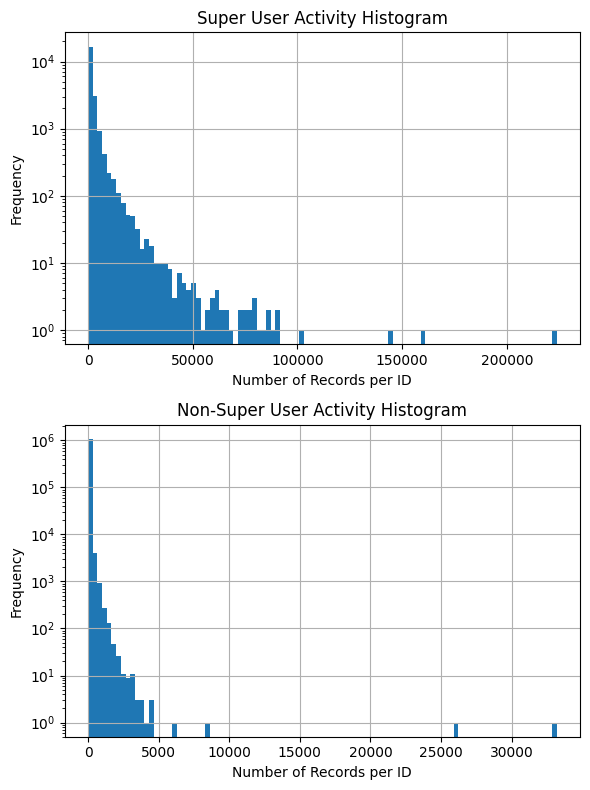

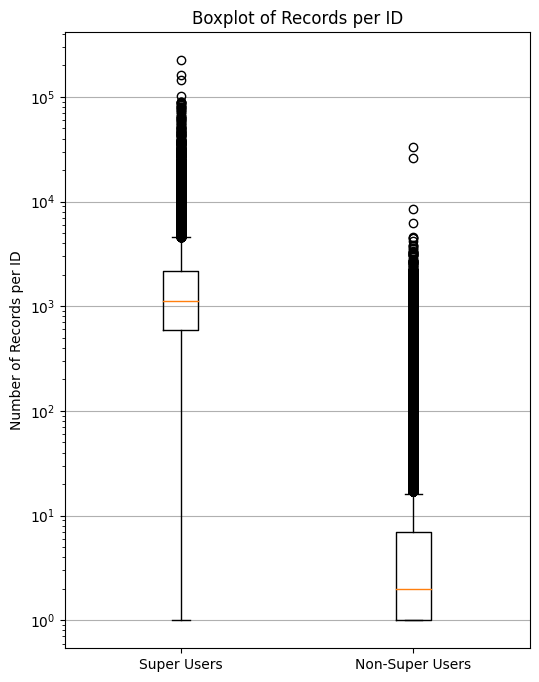

In [6]:
plt.figure(figsize=(6, 8))

plt.subplot(2, 1, 1)
super_activity["UserId"].value_counts().hist(bins=100)
plt.semilogy()
plt.title("Super User Activity Histogram")
plt.xlabel("Number of Records per ID")
plt.ylabel("Frequency")

plt.subplot(2, 1, 2)
non_super_activity["UserId"].value_counts().hist(bins=100)
plt.semilogy()
plt.title("Non-Super User Activity Histogram")
plt.xlabel("Number of Records per ID")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Create boxplots side by side in a single figure
plt.figure(figsize=(6, 8))

data = [
    super_activity["UserId"].value_counts(),
    non_super_activity["UserId"].value_counts()
]

plt.boxplot(data, labels=["Super Users", "Non-Super Users"])
plt.semilogy()
plt.title("Boxplot of Records per ID")
plt.ylabel("Number of Records per ID")
plt.grid(axis='y')

plt.show()


In [7]:
# number and percent of ids that have less than 10 records in each
print("Super Users")
super_counts = super_activity["UserId"].value_counts()
print(super_counts[super_counts < 10].shape[0])
print(super_counts[super_counts < 10].shape[0] / super_counts.shape[0])

print("Non-Super Users")
non_super_counts = non_super_activity["UserId"].value_counts()
print(non_super_counts[non_super_counts < 10].shape[0])
print(non_super_counts[non_super_counts < 10].shape[0] / non_super_counts.shape[0])

Super Users
27
0.0012236573759347384
Non-Super Users
852176
0.7916937632618478


In [8]:
# for each super user, organize their records by CreationDate
# then split the records into 10 bins and find the proportion of
# each ActionType in each bin
# Sort the dataframe by UserId and CreationDate
# Sort the super_activity DataFrame by UserId and CreationDate
start = time.time()
super_activity_sorted = super_activity.sort_values(
    by=["UserId", "CreationDate"]
).reset_index(drop=True)
print(f"Data sorted in {time.time() - start:.2f} seconds")

# Calculate the number of actions per user
user_action_counts = super_activity_sorted.groupby("UserId")["UserId"].transform(
    "count"
)

num_bins = 10
super_activity_sorted["Bin"] = super_activity_sorted.groupby("UserId").cumcount() // (
    user_action_counts // num_bins + 1
)
print(f"Binning done in {time.time() - start:.2f} seconds")

# Group by UserId, Bin, and ActionType and count occurrences
action_counts = (
    super_activity_sorted.groupby(["UserId", "Bin", "ActionType"])
    .size()
    .rename("count")
    .reset_index()
)
action_counts["Total"] = action_counts.groupby(["UserId", "Bin"])["count"].transform(
    "sum"
)

action_counts["Proportion"] = action_counts["count"] / action_counts["Total"]
print(f"Proportion calculation done in {time.time() - start:.2f} seconds")

start_pivot = time.time()
super_user_activity_proportions = action_counts.pivot_table(
    index=["UserId", "Bin"], columns="ActionType", values="Proportion", fill_value=0
).reset_index()
print(f"Pivoting done in {time.time() - start:.2f} seconds")

print(f"Total processing time: {time.time() - start:.2f} seconds")
print("Final DataFrame Shape:", super_user_activity_proportions.shape)
print("Final DataFrame Head:\n", super_user_activity_proportions.head())

Data sorted in 28.96 seconds
Binning done in 31.53 seconds
Proportion calculation done in 35.48 seconds
Pivoting done in 35.66 seconds
Total processing time: 35.66 seconds
Final DataFrame Shape: (219981, 6)
Final DataFrame Head:
 ActionType  UserId  Bin    Answer     Badge   Comment  Question
0                1    0  0.348837  0.441860  0.151163  0.058140
1                1    1  0.290698  0.279070  0.395349  0.034884
2                1    2  0.197674  0.302326  0.476744  0.023256
3                1    3  0.220930  0.290698  0.465116  0.023256
4                1    4  0.139535  0.174419  0.639535  0.046512


ActionType    Answer               Badge             Comment            Question          
                mean       std      mean       std      mean       std      mean       std
Bin                                                                                       
0           0.342423  0.183696  0.130369  0.109668  0.425345  0.176013  0.101863  0.138094
1           0.322392  0.180062  0.086497  0.126821  0.505853  0.176380  0.085258  0.135384
2           0.310543  0.178026  0.096108  0.143663  0.516411  0.180771  0.076937  0.126095
3           0.299168  0.176542  0.113493  0.163561  0.518494  0.187345  0.068844  0.114765
4           0.284841  0.174055  0.138552  0.186855  0.514270  0.195810  0.062337  0.103439


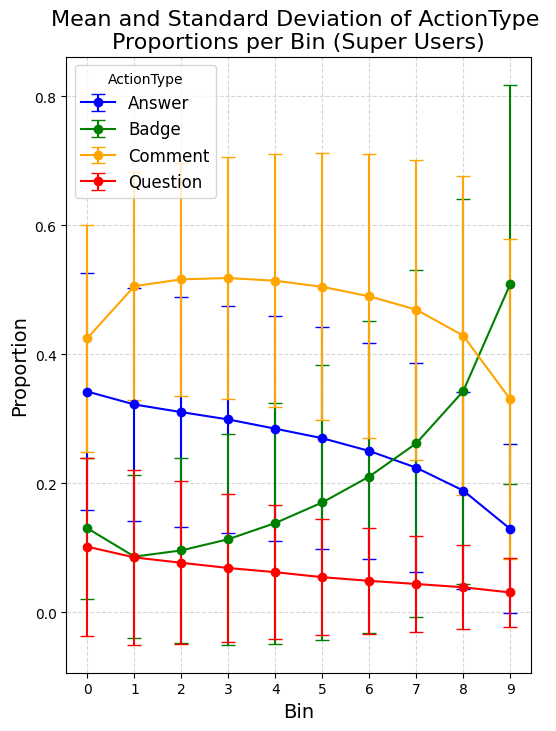

In [ ]:
import matplotlib.pyplot as plt

action_types = ['Answer', 'Badge', 'Comment', 'Question']

# Group by 'Bin' and calculate mean and standard deviation for each ActionType
grouped_stats = super_user_activity_proportions.groupby('Bin')[action_types].agg(['mean', 'std'])

# Display the grouped statistics
print(grouped_stats.head())

# Set the figure size for better readability
plt.figure(figsize=(6, 8))

# Define a color palette for different action types
colors = {
    'Answer': 'blue',
    'Badge': 'green',
    'Comment': 'orange',
    'Question': 'red'
}

# Iterate over each ActionType to plot
for action in action_types:
    plt.errorbar(
        grouped_stats.index,                        # Bins on x-axis
        grouped_stats[(action, 'mean')],           # Mean proportions on y-axis
        yerr=grouped_stats[(action, 'std')],        # Standard deviation as error bars
        label=action,                                # Label for the legend
        marker='o',                                  # Marker style
        linestyle='-',                               # Line style
        color=colors[action],                        # Color for each ActionType
        capsize=5                                     # Size of the error bar caps
    )

# Adding labels and title
plt.xlabel('Bin', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.title('Mean and Standard Deviation of ActionType \nProportions per Bin (Super Users)', fontsize=16)

# Adding a legend to differentiate ActionTypes
plt.legend(title='ActionType', fontsize=12)

# Setting x-axis ticks to show all bins
plt.xticks(grouped_stats.index)

# Adding a grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

plt.ylim(bottom=0)

# Display the plot
plt.show()


Counts pivoting done in 0.19 seconds
Statistics calculation done in 0.20 seconds


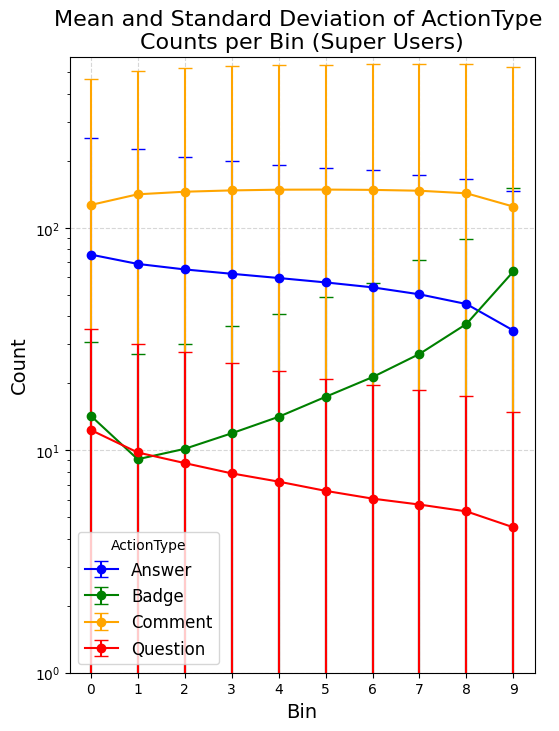

Plotting done in 0.44 seconds
Total processing time: 0.44 seconds
Final Counts DataFrame Shape: (219981, 6)
Final Counts DataFrame Head:
 ActionType  UserId  Bin  Answer  Badge  Comment  Question
0                1    0    30.0   38.0     13.0       5.0
1                1    1    25.0   24.0     34.0       3.0
2                1    2    17.0   26.0     41.0       2.0
3                1    3    19.0   25.0     40.0       2.0
4                1    4    12.0   15.0     55.0       4.0


In [10]:
import time
import matplotlib.pyplot as plt

# --- ActionType Counts Processing ---

# Start the timer
start = time.time()

# Pivot the action_counts DataFrame to have ActionTypes as separate columns with their counts
super_user_activity_counts = action_counts.pivot_table(
    index=["UserId", "Bin"],     # Rows indexed by UserId and Bin
    columns="ActionType",        # Columns for each ActionType
    values="count",              # Values are the counts of each ActionType
    fill_value=0                 # Fill missing values with 0
).reset_index()

print(f"Counts pivoting done in {time.time() - start:.2f} seconds")

# Define the action types you're interested in
action_types = ['Answer', 'Badge', 'Comment', 'Question']

# Calculate mean and standard deviation for each ActionType per Bin
grouped_stats_counts = super_user_activity_counts.groupby('Bin')[action_types].agg(['mean', 'std'])

print(f"Statistics calculation done in {time.time() - start:.2f} seconds")

# Plotting Mean and Standard Deviation of ActionType Counts per Bin
plt.figure(figsize=(6, 8))

# Define a color palette for different ActionTypes
colors = {
    'Answer': 'blue',
    'Badge': 'green',
    'Comment': 'orange',
    'Question': 'red'
}

# Iterate over each ActionType to plot
for action in action_types:
    plt.errorbar(
        grouped_stats_counts.index,                         # Bins on x-axis
        grouped_stats_counts[(action, 'mean')],            # Mean counts on y-axis
        yerr=grouped_stats_counts[(action, 'std')],         # Standard deviation as error bars
        label=action,                                       # Label for the legend
        marker='o',                                         # Marker style
        linestyle='-',                                      # Line style
        color=colors[action],                               # Color for each ActionType
        capsize=5                                            # Size of the error bar caps
    )

# Adding labels and title
plt.xlabel('Bin', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Mean and Standard Deviation of ActionType \nCounts per Bin (Super Users)', fontsize=16)

# Adding a legend to differentiate ActionTypes
plt.legend(title='ActionType', fontsize=12)

# Setting x-axis ticks to show all bins
plt.xticks(grouped_stats_counts.index)

# Adding a grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

plt.ylim(bottom=1)

plt.semilogy()

# Display the plot
plt.show()

print(f"Plotting done in {time.time() - start:.2f} seconds")
print(f"Total processing time: {time.time() - start:.2f} seconds")
print("Final Counts DataFrame Shape:", super_user_activity_counts.shape)
print("Final Counts DataFrame Head:\n", super_user_activity_counts.head())


Non-Super Users Data sorted in 11.51 seconds
Non-Super Users Binning done in 12.49 seconds
Non-Super Users Proportion calculation done in 15.31 seconds
Non-Super Users Proportions Pivoting done in 1.89 seconds
Non-Super Users Total processing time for Proportions: 17.20 seconds
Non-Super Users Final Proportions DataFrame Shape: (3955194, 6)
Non-Super Users Final Proportions DataFrame Head:
 ActionType  UserId  Bin    Answer     Badge   Comment  Question
0               37    0  0.344828  0.448276  0.068966  0.137931
1               37    1  0.206897  0.034483  0.586207  0.172414
2               37    2  0.206897  0.137931  0.551724  0.103448
3               37    3  0.137931  0.137931  0.586207  0.137931
4               37    4  0.241379  0.241379  0.413793  0.103448
Non-Super Users Counts pivoting done in 1.88 seconds
Non-Super Users Statistics calculation done in 2.02 seconds


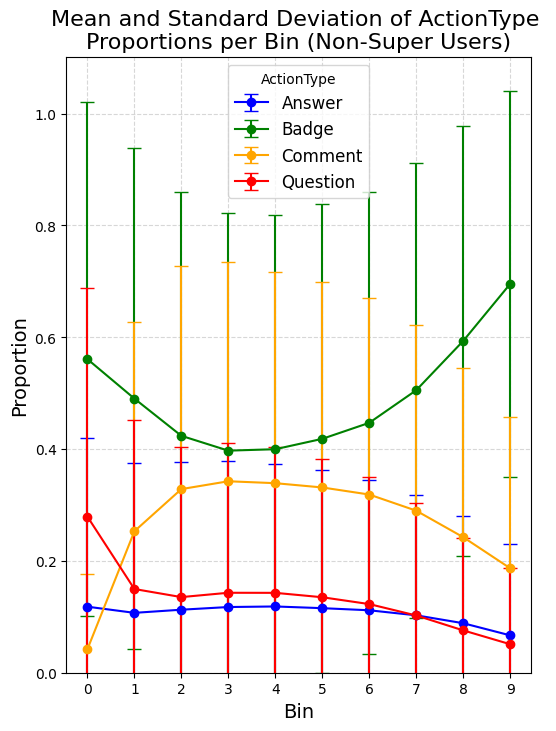

Non-Super Users Proportions Plotting done in 2.53 seconds


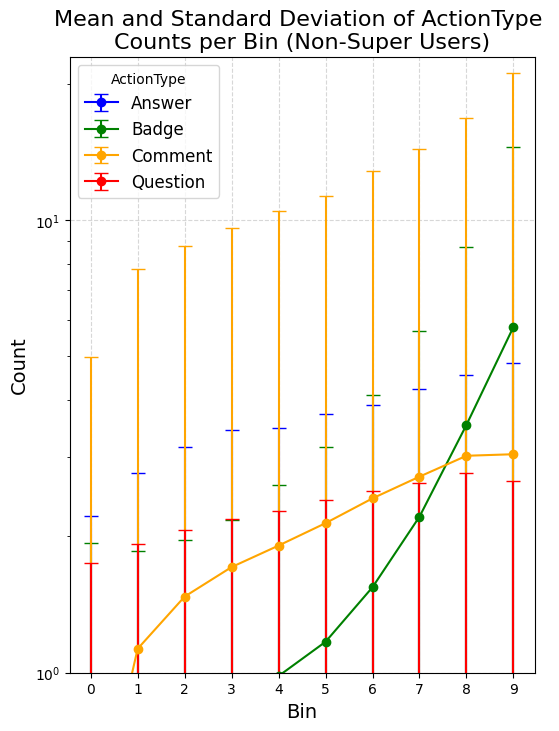

Non-Super Users Counts Plotting done in 2.85 seconds
Non-Super Users Total processing time for Counts: 2.85 seconds
Non-Super Users Final Counts DataFrame Shape: (3955194, 6)
Non-Super Users Final Counts DataFrame Head:
 ActionType  UserId  Bin  Answer  Badge  Comment  Question
0               37    0    10.0   13.0      2.0       4.0
1               37    1     6.0    1.0     17.0       5.0
2               37    2     6.0    4.0     16.0       3.0
3               37    3     4.0    4.0     17.0       4.0
4               37    4     7.0    7.0     12.0       3.0


In [11]:
import time
import matplotlib.pyplot as plt

# --- Non-Super Users ActionType Proportions Processing ---

# Start the timer
start = time.time()

# Sort the non_super_activity DataFrame by UserId and CreationDate
non_super_activity_sorted = non_super_activity.sort_values(
    by=["UserId", "CreationDate"]
).reset_index(drop=True)
print(f"Non-Super Users Data sorted in {time.time() - start:.2f} seconds")

# Calculate the number of actions per user
user_action_counts_non_super = non_super_activity_sorted.groupby("UserId")[
    "UserId"
].transform("count")

# Define the number of bins
num_bins = 10

# Assign bin numbers to each record
non_super_activity_sorted["Bin"] = non_super_activity_sorted.groupby(
    "UserId"
).cumcount() // (user_action_counts_non_super // num_bins + 1)
print(f"Non-Super Users Binning done in {time.time() - start:.2f} seconds")

# Group by UserId, Bin, and ActionType and count occurrences
action_counts_non_super = (
    non_super_activity_sorted.groupby(["UserId", "Bin", "ActionType"])
    .size()
    .rename("count")
    .reset_index()
)
action_counts_non_super["Total"] = action_counts_non_super.groupby(["UserId", "Bin"])[
    "count"
].transform("sum")

# Calculate proportions
action_counts_non_super["Proportion"] = (
    action_counts_non_super["count"] / action_counts_non_super["Total"]
)
print(
    f"Non-Super Users Proportion calculation done in {time.time() - start:.2f} seconds"
)

# Pivot the data to get proportions
start_pivot_non_super = time.time()
non_super_user_activity_proportions = action_counts_non_super.pivot_table(
    index=["UserId", "Bin"], columns="ActionType", values="Proportion", fill_value=0
).reset_index()
print(
    f"Non-Super Users Proportions Pivoting done in {time.time() - start_pivot_non_super:.2f} seconds"
)

print(
    f"Non-Super Users Total processing time for Proportions: {time.time() - start:.2f} seconds"
)
print(
    "Non-Super Users Final Proportions DataFrame Shape:",
    non_super_user_activity_proportions.shape,
)
print(
    "Non-Super Users Final Proportions DataFrame Head:\n",
    non_super_user_activity_proportions.head(),
)

# --- Non-Super Users ActionType Counts Processing ---

# Start the timer for counts processing
start_counts_non_super = time.time()

# Pivot the action_counts_non_super DataFrame to have ActionTypes as separate columns with their counts
non_super_user_activity_counts = action_counts_non_super.pivot_table(
    index=["UserId", "Bin"],  # Rows indexed by UserId and Bin
    columns="ActionType",  # Columns for each ActionType
    values="count",  # Values are the counts of each ActionType
    fill_value=0,  # Fill missing values with 0
).reset_index()

print(
    f"Non-Super Users Counts pivoting done in {time.time() - start_counts_non_super:.2f} seconds"
)

# Define the action types you're interested in
action_types = ["Answer", "Badge", "Comment", "Question"]

# Calculate mean and standard deviation for each ActionType per Bin
grouped_stats_counts_non_super = non_super_user_activity_counts.groupby("Bin")[
    action_types
].agg(["mean", "std"])

print(
    f"Non-Super Users Statistics calculation done in {time.time() - start_counts_non_super:.2f} seconds"
)

# --- Plotting ---

# Plot 1: Proportions
plt.figure(figsize=(6, 8))

# Define a color palette for different ActionTypes
colors = {"Answer": "blue", "Badge": "green", "Comment": "orange", "Question": "red"}

# Iterate over each ActionType to plot proportions
for action in action_types:
    if action in non_super_user_activity_proportions.columns:
        plt.errorbar(
            grouped_stats_counts_non_super.index,  # Using counts' grouped_stats for consistent bin indexing
            non_super_user_activity_proportions.groupby("Bin")[
                action
            ].mean(),  # Mean proportions per bin
            yerr=non_super_user_activity_proportions.groupby("Bin")[
                action
            ].std(),  # Std dev proportions per bin
            label=action,
            marker="o",
            linestyle="-",
            color=colors[action],
            capsize=5,
        )
    else:
        print(f"ActionType '{action}' not found in Proportions DataFrame.")

# Adding labels and title for Proportions plot
plt.xlabel("Bin", fontsize=14)
plt.ylabel("Proportion", fontsize=14)
plt.title(
    "Mean and Standard Deviation of ActionType \nProportions per Bin (Non-Super Users)",
    fontsize=16,
)
plt.legend(title="ActionType", fontsize=12)
plt.xticks(grouped_stats_counts_non_super.index)
plt.grid(True, linestyle="--", alpha=0.5)
plt.ylim(bottom=0)  # Since proportions range between 0 and 1
plt.show()

print(
    f"Non-Super Users Proportions Plotting done in {time.time() - start_counts_non_super:.2f} seconds"
)

# Plot 2: Counts
plt.figure(figsize=(6, 8))

# Iterate over each ActionType to plot counts
for action in action_types:
    if action in grouped_stats_counts_non_super.columns.get_level_values(0):
        plt.errorbar(
            grouped_stats_counts_non_super.index,  # Bins on x-axis
            grouped_stats_counts_non_super[(action, "mean")],  # Mean counts on y-axis
            yerr=grouped_stats_counts_non_super[
                (action, "std")
            ],  # Standard deviation as error bars
            label=action,  # Label for the legend
            marker="o",  # Marker style
            linestyle="-",  # Line style
            color=colors[action],  # Color for each ActionType
            capsize=5,  # Size of the error bar caps
        )
    else:
        print(f"ActionType '{action}' not found in Counts DataFrame.")

# Adding labels and title for Counts plot
plt.xlabel("Bin", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title(
    "Mean and Standard Deviation of ActionType \nCounts per Bin (Non-Super Users)",
    fontsize=16,
)
plt.legend(title="ActionType", fontsize=12)
plt.xticks(grouped_stats_counts_non_super.index)
plt.grid(True, linestyle="--", alpha=0.5)
plt.ylim(bottom=1)
plt.semilogy()  # Applying logarithmic scale to y-axis for counts
plt.show()

print(
    f"Non-Super Users Counts Plotting done in {time.time() - start_counts_non_super:.2f} seconds"
)
print(
    f"Non-Super Users Total processing time for Counts: {time.time() - start_counts_non_super:.2f} seconds"
)
print(
    "Non-Super Users Final Counts DataFrame Shape:",
    non_super_user_activity_counts.shape,
)
print(
    "Non-Super Users Final Counts DataFrame Head:\n",
    non_super_user_activity_counts.head(),
)

Non-Super Users Data sorted in 11.55 seconds
Non-Super Users Binning done in 12.58 seconds
Non-Super Users Proportion calculation done in 15.45 seconds
Non-Super Users Proportions Pivoting done in 1.92 seconds
Non-Super Users Total processing time for Proportions: 17.37 seconds
Non-Super Users Final Proportions DataFrame Shape: (3955194, 6)
Non-Super Users Final Proportions DataFrame Head:
 ActionType  UserId  Bin    Answer     Badge   Comment  Question
0               37    0  0.344828  0.448276  0.068966  0.137931
1               37    1  0.206897  0.034483  0.586207  0.172414
2               37    2  0.206897  0.137931  0.551724  0.103448
3               37    3  0.137931  0.137931  0.586207  0.137931
4               37    4  0.241379  0.241379  0.413793  0.103448
Non-Super Users Counts pivoting done in 1.91 seconds
Non-Super Users Statistics calculation done in 2.04 seconds


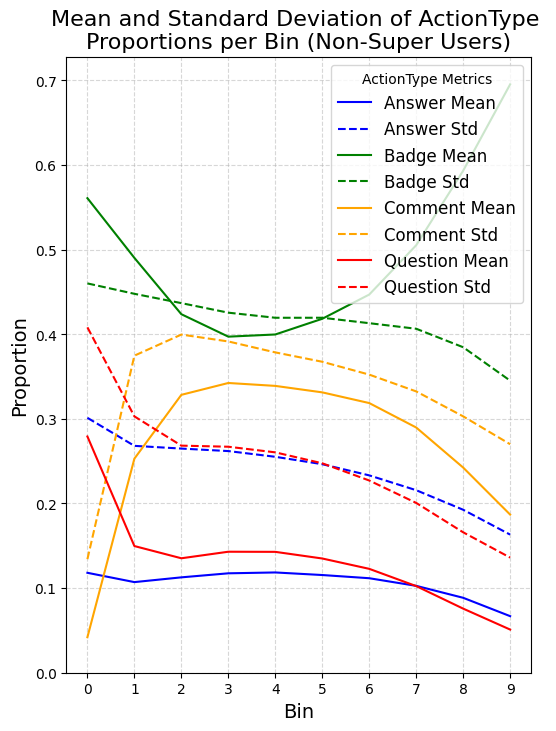

Non-Super Users Proportions Plotting done in 2.33 seconds


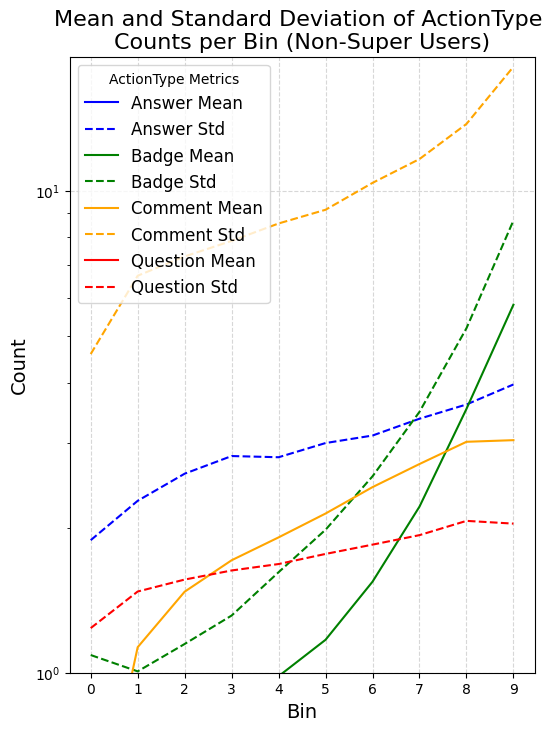

Non-Super Users Counts Plotting done in 2.52 seconds
Non-Super Users Total processing time for Counts: 2.52 seconds
Non-Super Users Final Counts DataFrame Shape: (3955194, 6)
Non-Super Users Final Counts DataFrame Head:
 ActionType  UserId  Bin  Answer  Badge  Comment  Question
0               37    0    10.0   13.0      2.0       4.0
1               37    1     6.0    1.0     17.0       5.0
2               37    2     6.0    4.0     16.0       3.0
3               37    3     4.0    4.0     17.0       4.0
4               37    4     7.0    7.0     12.0       3.0


In [12]:
import time
import matplotlib.pyplot as plt

# --- Non-Super Users ActionType Proportions Processing ---

# Start the timer
start = time.time()

# Sort the non_super_activity DataFrame by UserId and CreationDate
non_super_activity_sorted = non_super_activity.sort_values(
    by=["UserId", "CreationDate"]
).reset_index(drop=True)
print(f"Non-Super Users Data sorted in {time.time() - start:.2f} seconds")

# Calculate the number of actions per user
user_action_counts_non_super = non_super_activity_sorted.groupby("UserId")["UserId"].transform(
    "count"
)

# Define the number of bins
num_bins = 10

# Assign bin numbers to each record
non_super_activity_sorted["Bin"] = non_super_activity_sorted.groupby(
    "UserId"
).cumcount() // (user_action_counts_non_super // num_bins + 1)
print(f"Non-Super Users Binning done in {time.time() - start:.2f} seconds")

# Group by UserId, Bin, and ActionType and count occurrences
action_counts_non_super = (
    non_super_activity_sorted.groupby(["UserId", "Bin", "ActionType"])
    .size()
    .rename("count")
    .reset_index()
)
action_counts_non_super["Total"] = action_counts_non_super.groupby(["UserId", "Bin"])["count"].transform(
    "sum"
)

# Calculate proportions
action_counts_non_super["Proportion"] = (
    action_counts_non_super["count"] / action_counts_non_super["Total"]
)
print(
    f"Non-Super Users Proportion calculation done in {time.time() - start:.2f} seconds"
)

# Pivot the data to get proportions
start_pivot_non_super = time.time()
non_super_user_activity_proportions = action_counts_non_super.pivot_table(
    index=["UserId", "Bin"], 
    columns="ActionType", 
    values="Proportion", 
    fill_value=0
).reset_index()
print(
    f"Non-Super Users Proportions Pivoting done in {time.time() - start_pivot_non_super:.2f} seconds"
)

print(
    f"Non-Super Users Total processing time for Proportions: {time.time() - start:.2f} seconds"
)
print(
    "Non-Super Users Final Proportions DataFrame Shape:",
    non_super_user_activity_proportions.shape,
)
print(
    "Non-Super Users Final Proportions DataFrame Head:\n",
    non_super_user_activity_proportions.head(),
)

# --- Non-Super Users ActionType Counts Processing ---

# Start the timer for counts processing
start_counts_non_super = time.time()

# Pivot the action_counts_non_super DataFrame to have ActionTypes as separate columns with their counts
non_super_user_activity_counts = action_counts_non_super.pivot_table(
    index=["UserId", "Bin"],  # Rows indexed by UserId and Bin
    columns="ActionType",      # Columns for each ActionType
    values="count",            # Values are the counts of each ActionType
    fill_value=0,              # Fill missing values with 0
).reset_index()

print(
    f"Non-Super Users Counts pivoting done in {time.time() - start_counts_non_super:.2f} seconds"
)

# Define the action types you're interested in
action_types = ["Answer", "Badge", "Comment", "Question"]

# Calculate mean and standard deviation for each ActionType per Bin
grouped_stats_counts_non_super = non_super_user_activity_counts.groupby("Bin")[
    action_types
].agg(["mean", "std"])

print(
    f"Non-Super Users Statistics calculation done in {time.time() - start_counts_non_super:.2f} seconds"
)

# Flatten the MultiIndex columns for counts
grouped_stats_counts_non_super.columns = [
    f"{action}_{stat}" for action, stat in grouped_stats_counts_non_super.columns
]
grouped_stats_counts_non_super = grouped_stats_counts_non_super.reset_index()

# --- Plotting ---

# Define a color palette for different ActionTypes
colors = {"Answer": "blue", "Badge": "green", "Comment": "orange", "Question": "red"}

# ----- Plot 1: Proportions -----
plt.figure(figsize=(6, 8))

# Calculate mean and std for proportions
grouped_stats_proportions_non_super = non_super_user_activity_proportions.groupby("Bin")[
    action_types
].agg(["mean", "std"])

# Flatten the MultiIndex columns for proportions
grouped_stats_proportions_non_super.columns = [
    f"{action}_{stat}" for action, stat in grouped_stats_proportions_non_super.columns
]
grouped_stats_proportions_non_super = grouped_stats_proportions_non_super.reset_index()

# Iterate over each ActionType to plot proportions
for action in action_types:
    mean_col = f"{action}_mean"
    std_col = f"{action}_std"
    
    if mean_col in grouped_stats_proportions_non_super.columns and std_col in grouped_stats_proportions_non_super.columns:
        # Convert to NumPy arrays
        x = grouped_stats_proportions_non_super["Bin"].values
        mean_values = grouped_stats_proportions_non_super[mean_col].values
        std_values = grouped_stats_proportions_non_super[std_col].values
        
        # Plot mean as solid line
        plt.plot(
            x,
            mean_values,
            label=f"{action} Mean",
            color=colors[action],
            linestyle="-",
        )
        # Plot std as dotted line
        plt.plot(
            x,
            std_values,
            label=f"{action} Std",
            color=colors[action],
            linestyle="--",
        )
    else:
        print(f"ActionType '{action}' not found in Proportions DataFrame.")

# Adding labels and title for Proportions plot
plt.xlabel("Bin", fontsize=14)
plt.ylabel("Proportion", fontsize=14)
plt.title(
    "Mean and Standard Deviation of ActionType \nProportions per Bin (Non-Super Users)",
    fontsize=16,
)
plt.legend(title="ActionType Metrics", fontsize=12, loc='upper right')
plt.xticks(grouped_stats_proportions_non_super["Bin"].unique())
plt.grid(True, linestyle="--", alpha=0.5)
plt.ylim(bottom=0)  # Since proportions range between 0 and 1
plt.show()

print(
    f"Non-Super Users Proportions Plotting done in {time.time() - start_counts_non_super:.2f} seconds"
)

# ----- Plot 2: Counts -----
plt.figure(figsize=(6, 8))

# Iterate over each ActionType to plot counts
for action in action_types:
    mean_col = f"{action}_mean"
    std_col = f"{action}_std"
    
    if mean_col in grouped_stats_counts_non_super.columns and std_col in grouped_stats_counts_non_super.columns:
        # Convert to NumPy arrays
        x = grouped_stats_counts_non_super["Bin"].values
        mean_values = grouped_stats_counts_non_super[mean_col].values
        std_values = grouped_stats_counts_non_super[std_col].values
        
        # Plot mean as solid line
        plt.plot(
            x,
            mean_values,
            label=f"{action} Mean",
            color=colors[action],
            linestyle="-",
        )
        # Plot std as dotted line
        plt.plot(
            x,
            std_values,
            label=f"{action} Std",
            color=colors[action],
            linestyle="--",
        )
    else:
        print(f"ActionType '{action}' not found in Counts DataFrame.")

# Adding labels and title for Counts plot
plt.xlabel("Bin", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title(
    "Mean and Standard Deviation of ActionType \nCounts per Bin (Non-Super Users)",
    fontsize=16,
)
plt.legend(title="ActionType Metrics", fontsize=12, loc='upper left')
plt.xticks(grouped_stats_counts_non_super["Bin"].unique())
plt.grid(True, linestyle="--", alpha=0.5)
plt.ylim(bottom=1)
plt.semilogy()  # Applying logarithmic scale to y-axis for counts
plt.show()

print(
    f"Non-Super Users Counts Plotting done in {time.time() - start_counts_non_super:.2f} seconds"
)
print(
    f"Non-Super Users Total processing time for Counts: {time.time() - start_counts_non_super:.2f} seconds"
)
print(
    "Non-Super Users Final Counts DataFrame Shape:",
    non_super_user_activity_counts.shape,
)
print(
    "Non-Super Users Final Counts DataFrame Head:\n",
    non_super_user_activity_counts.head(),
)


Super Users Data sorted in 30.05 seconds
Super Users Binning done in 32.64 seconds
Super Users Proportion calculation done in 36.50 seconds
Super Users Proportions Pivoting done in 0.23 seconds
Super Users Total processing time for Proportions: 36.73 seconds
Super Users Final Proportions DataFrame Shape: (219981, 6)
Super Users Final Proportions DataFrame Head:
 ActionType  UserId  Bin    Answer     Badge   Comment  Question
0                1    0  0.348837  0.441860  0.151163  0.058140
1                1    1  0.290698  0.279070  0.395349  0.034884
2                1    2  0.197674  0.302326  0.476744  0.023256
3                1    3  0.220930  0.290698  0.465116  0.023256
4                1    4  0.139535  0.174419  0.639535  0.046512
Super Users Counts pivoting done in 0.20 seconds
Super Users Statistics calculation done in 0.22 seconds


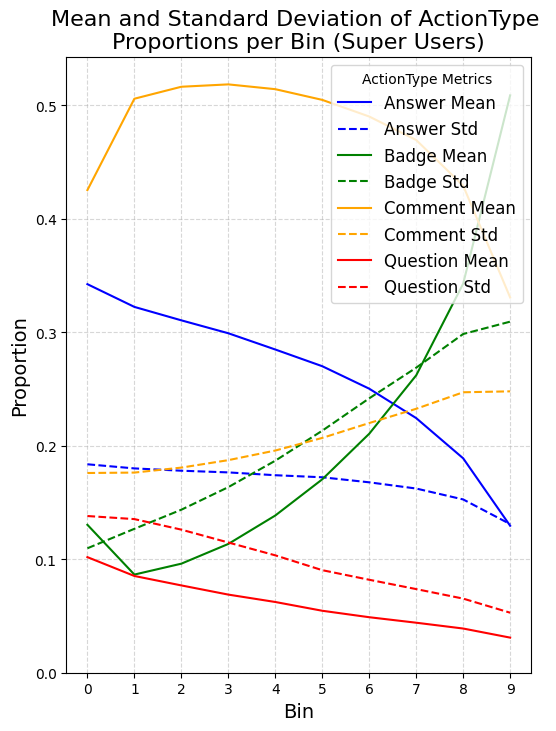

Super Users Proportions Plotting done in 0.35 seconds


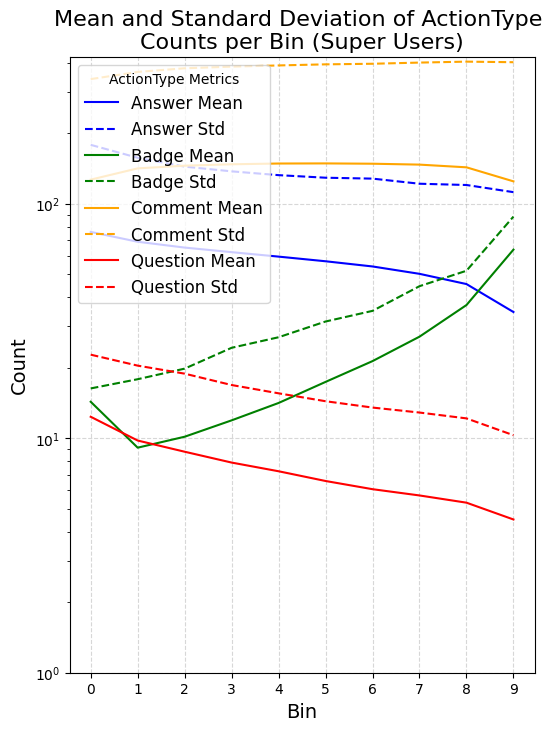

Super Users Counts Plotting done in 0.62 seconds
Super Users Total processing time for Counts: 0.62 seconds
Super Users Final Counts DataFrame Shape: (219981, 6)
Super Users Final Counts DataFrame Head:
 ActionType  UserId  Bin  Answer  Badge  Comment  Question
0                1    0    30.0   38.0     13.0       5.0
1                1    1    25.0   24.0     34.0       3.0
2                1    2    17.0   26.0     41.0       2.0
3                1    3    19.0   25.0     40.0       2.0
4                1    4    12.0   15.0     55.0       4.0


In [13]:
import time
import matplotlib.pyplot as plt

# --- Super Users ActionType Proportions Processing ---

# Start the timer
start = time.time()

# Sort the super_activity DataFrame by UserId and CreationDate
super_activity_sorted = super_activity.sort_values(
    by=["UserId", "CreationDate"]
).reset_index(drop=True)
print(f"Super Users Data sorted in {time.time() - start:.2f} seconds")

# Calculate the number of actions per user
user_action_counts_super = super_activity_sorted.groupby("UserId")["UserId"].transform(
    "count"
)

# Define the number of bins
num_bins = 10

# Assign bin numbers to each record
super_activity_sorted["Bin"] = super_activity_sorted.groupby(
    "UserId"
).cumcount() // (user_action_counts_super // num_bins + 1)
print(f"Super Users Binning done in {time.time() - start:.2f} seconds")

# Group by UserId, Bin, and ActionType and count occurrences
action_counts_super = (
    super_activity_sorted.groupby(["UserId", "Bin", "ActionType"])
    .size()
    .rename("count")
    .reset_index()
)
action_counts_super["Total"] = action_counts_super.groupby(["UserId", "Bin"])["count"].transform(
    "sum"
)

# Calculate proportions
action_counts_super["Proportion"] = (
    action_counts_super["count"] / action_counts_super["Total"]
)
print(
    f"Super Users Proportion calculation done in {time.time() - start:.2f} seconds"
)

# Pivot the data to get proportions
start_pivot_super = time.time()
super_user_activity_proportions = action_counts_super.pivot_table(
    index=["UserId", "Bin"], 
    columns="ActionType", 
    values="Proportion", 
    fill_value=0
).reset_index()
print(
    f"Super Users Proportions Pivoting done in {time.time() - start_pivot_super:.2f} seconds"
)

print(
    f"Super Users Total processing time for Proportions: {time.time() - start:.2f} seconds"
)
print(
    "Super Users Final Proportions DataFrame Shape:",
    super_user_activity_proportions.shape,
)
print(
    "Super Users Final Proportions DataFrame Head:\n",
    super_user_activity_proportions.head(),
)

# --- Super Users ActionType Counts Processing ---

# Start the timer for counts processing
start_counts_super = time.time()

# Pivot the action_counts_super DataFrame to have ActionTypes as separate columns with their counts
super_user_activity_counts = action_counts_super.pivot_table(
    index=["UserId", "Bin"],  # Rows indexed by UserId and Bin
    columns="ActionType",      # Columns for each ActionType
    values="count",            # Values are the counts of each ActionType
    fill_value=0,              # Fill missing values with 0
).reset_index()

print(
    f"Super Users Counts pivoting done in {time.time() - start_counts_super:.2f} seconds"
)

# Define the action types you're interested in
action_types = ["Answer", "Badge", "Comment", "Question"]

# Calculate mean and standard deviation for each ActionType per Bin
grouped_stats_counts_super = super_user_activity_counts.groupby("Bin")[
    action_types
].agg(["mean", "std"])

print(
    f"Super Users Statistics calculation done in {time.time() - start_counts_super:.2f} seconds"
)

# Flatten the MultiIndex columns for counts
grouped_stats_counts_super.columns = [
    f"{action}_{stat}" for action, stat in grouped_stats_counts_super.columns
]
grouped_stats_counts_super = grouped_stats_counts_super.reset_index()

# --- Plotting ---

# Define a color palette for different ActionTypes
colors = {"Answer": "blue", "Badge": "green", "Comment": "orange", "Question": "red"}

# ----- Plot 1: Proportions -----
plt.figure(figsize=(6, 8))

# Calculate mean and std for proportions
grouped_stats_proportions_super = super_user_activity_proportions.groupby("Bin")[
    action_types
].agg(["mean", "std"])

# Flatten the MultiIndex columns for proportions
grouped_stats_proportions_super.columns = [
    f"{action}_{stat}" for action, stat in grouped_stats_proportions_super.columns
]
grouped_stats_proportions_super = grouped_stats_proportions_super.reset_index()

# Iterate over each ActionType to plot proportions
for action in action_types:
    mean_col = f"{action}_mean"
    std_col = f"{action}_std"
    
    if mean_col in grouped_stats_proportions_super.columns and std_col in grouped_stats_proportions_super.columns:
        # Convert to NumPy arrays
        x = grouped_stats_proportions_super["Bin"].values
        mean_values = grouped_stats_proportions_super[mean_col].values
        std_values = grouped_stats_proportions_super[std_col].values
        
        # Plot mean as solid line
        plt.plot(
            x,
            mean_values,
            label=f"{action} Mean",
            color=colors[action],
            linestyle="-",
        )
        # Plot std as dotted line
        plt.plot(
            x,
            std_values,
            label=f"{action} Std",
            color=colors[action],
            linestyle="--",
        )
    else:
        print(f"ActionType '{action}' not found in Proportions DataFrame.")

# Adding labels and title for Proportions plot
plt.xlabel("Bin", fontsize=14)
plt.ylabel("Proportion", fontsize=14)
plt.title(
    "Mean and Standard Deviation of ActionType \nProportions per Bin (Super Users)",
    fontsize=16,
)
plt.legend(title="ActionType Metrics", fontsize=12, loc='upper right')
plt.xticks(grouped_stats_proportions_super["Bin"].unique())
plt.grid(True, linestyle="--", alpha=0.5)
plt.ylim(bottom=0)  # Since proportions range between 0 and 1
plt.show()

print(
    f"Super Users Proportions Plotting done in {time.time() - start_counts_super:.2f} seconds"
)

# ----- Plot 2: Counts -----
plt.figure(figsize=(6, 8))

# Iterate over each ActionType to plot counts
for action in action_types:
    mean_col = f"{action}_mean"
    std_col = f"{action}_std"
    
    if mean_col in grouped_stats_counts_super.columns and std_col in grouped_stats_counts_super.columns:
        # Convert to NumPy arrays
        x = grouped_stats_counts_super["Bin"].values
        mean_values = grouped_stats_counts_super[mean_col].values
        std_values = grouped_stats_counts_super[std_col].values
        
        # Plot mean as solid line
        plt.plot(
            x,
            mean_values,
            label=f"{action} Mean",
            color=colors[action],
            linestyle="-",
        )
        # Plot std as dotted line
        plt.plot(
            x,
            std_values,
            label=f"{action} Std",
            color=colors[action],
            linestyle="--",
        )
    else:
        print(f"ActionType '{action}' not found in Counts DataFrame.")

# Adding labels and title for Counts plot
plt.xlabel("Bin", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title(
    "Mean and Standard Deviation of ActionType \nCounts per Bin (Super Users)",
    fontsize=16,
)
plt.legend(title="ActionType Metrics", fontsize=12, loc='upper left')
plt.xticks(grouped_stats_counts_super["Bin"].unique())
plt.grid(True, linestyle="--", alpha=0.5)
plt.ylim(bottom=1)
plt.semilogy()  # Applying logarithmic scale to y-axis for counts
plt.show()

print(
    f"Super Users Counts Plotting done in {time.time() - start_counts_super:.2f} seconds"
)
print(
    f"Super Users Total processing time for Counts: {time.time() - start_counts_super:.2f} seconds"
)
print(
    "Super Users Final Counts DataFrame Shape:",
    super_user_activity_counts.shape,
)
print(
    "Super Users Final Counts DataFrame Head:\n",
    super_user_activity_counts.head(),
)
